#### $\text{Deep Learning (AI2100/AI5100): Assignment-3}$
$\text{Name: Shagun}$  
$\text{Roll No: CS23MTECH14013}$

##### $\text{Importing libraries }$

In [1]:
!pip install torchsummary

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torchsummary import summary


##### $\text{Problem 1. Self-Attention for Object Recognition with CNNs}$ [10 Marks]
Implement a sample CNN with one or
more self-attention layer(s) for performing object recognition over CIFAR-10 dataset. You have to
implement the self-attention layer yourself and use it in the forward function defined by you. All
other layers (fully connected, nonlinearity, conv layer, etc.) can be bulit-in implementations. The
network can be a simpler one (e.g., it may have 1x Conv, 4x [Conv followed by SA], 1x Conv, and
1x GAP). Please refer to the reading material provided here or any other similar one.

### Solution 1

`SelfAttention`

1. **Initialization**:
   - `__init__` method:  It takes two arguments: `input_channels` and `input_dim`, which represent the number of input channels and the dimension of each channel respectively.
   - Inside the `__init__` method:
     - `input_channels` and `input_dim` are stored as attributes of the module.
     - Three linear layers (`query_mat`, `key_mat`, and `value_mat`) are initialized using `nn.Linear`. Each linear layer takes an input of size `input_dim**2` and produces an output of size `input_dim**2`. These layers are used to transform the input data into query, key, and value vectors.

2. **Forward Pass**:
   - `forward` method: This method defines the forward pass of the `SelfAttention` module.
   - Inside the `forward` method:
     - The input tensor `x` is reshaped using `view` to have a shape of `(batch_size, input_channels, input_dim**2)`.
     - The input tensor is passed through each of the linear layers (`query_mat`, `key_mat`, and `value_mat`) to obtain query, key, and value tensors respectively.
     - The attention score is computed by taking the dot product of query and key tensors, and then divided by `self.input_dim` to normalize the scores.
     - Softmax is applied along the second dimension of the attention score tensor to obtain attention probabilities.
     - The attention probabilities are used to compute the weighted sum of value vectors, resulting in the attention output.
     - Finally, the attention output tensor is reshaped to its original shape `(batch_size, input_channels, input_dim, input_dim)` and returned.


In [2]:
class SelfAttention(nn.Module):
    def __init__(self, input_channels, input_dim):
        super(SelfAttention, self).__init__()
        self.input_channels = input_channels
        self.input_dim = input_dim
        self.query_mat = nn.Linear(input_dim**2, input_dim**2, bias=False)
        self.key_mat = nn.Linear(input_dim**2, input_dim**2, bias=False)
        self.value_mat = nn.Linear(input_dim**2, input_dim**2, bias=False)


#         self.output_linear = nn.Linear(input_dim**2, input_dim**2, bias=False)  #this line

    def forward(self, x):
        x = x.view(-1, self.input_channels,self.input_dim**2)
        query = self.query_mat(x)
        key = self.key_mat(x)
        value = self.value_mat(x)

        attention_score = torch.bmm(query, key.transpose(1, 2)) / (self.input_dim)
        attention_probs = F.softmax(attention_score, dim=1)
        attention_outs = torch.bmm(attention_probs, value)

#         output = self.output_linear(attention_outs)

        attention_output = attention_outs.view(-1,self.input_channels, self.input_dim, self.input_dim)

        return attention_output


 module named `Norm` implements a layer normalization operation. Layer normalization is a technique used in neural networks to normalize the activations of each layer across the feature dimension.

1. **Initialization**:
   - `__init__` method: It takes two arguments: `d_model`, which represents the size of the input feature dimension, and `eps`, which is a small value added to the denominator for numerical stability.
   - Inside the `__init__` method:
     - The size of the input feature dimension (`d_model`) is stored as an attribute of the module.
     - Two learnable parameters, `alpha` and `bias`, are initialized as `nn.Parameter` objects. `alpha` is a tensor initialized with ones, and `bias` is a tensor initialized with zeros. Both tensors have the same size as the input feature dimension (`d_model`).
     - `eps` is stored as an attribute of the module.

2. **Forward Pass**:
   - Inside the `forward` method:
     - The input tensor `x` is normalized using layer normalization formula:
       ```
       norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
       ```
       Here:
       - `x.mean(dim=-1, keepdim=True)` computes the mean of each instance along the last dimension (feature dimension) while keeping the dimensionality unchanged.
       - `x.std(dim=-1, keepdim=True)` computes the standard deviation of each instance along the last dimension while keeping the dimensionality unchanged.
       - `self.alpha` scales the normalized values.
       - `self.bias` adds a bias term.
       - `self.eps` is added to the denominator for numerical stability.
     - The normalized tensor `norm` is returned.

In summary, the `Norm` module performs layer normalization on the input tensor `x`, applying learnable scaling (`alpha`) and shifting (`bias`) parameters to normalize the activations across the feature dimension.

In [3]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

This code defines a residual block (`ResBlk`) which helps in overcoming the vanishing gradient problem and facilitate the training of very deep networks.

1. **Initialization**:
   - `__init__` method: It takes one argument `c`, which represents the number of input channels.
   - Inside the `__init__` method:
     - Four convolutional layers (`rn1`, `rn2`, `rn3`, and `rn4`) are initialized using `nn.Conv2d`. Each convolutional layer has `c` input channels, `c` output channels, a kernel size of 3x3, a stride of 1, and padding of 1. These layers perform convolution operations.
     - Four batch normalization layers (`bn6`, `bn7`, `bn8`, and `bn9`) are initialized using `nn.BatchNorm2d`. Each batch normalization layer has `c` input channels. Batch normalization helps in stabilizing and accelerating the training of deep neural networks.

2. **Forward Pass**:
   - Inside the `forward` method:
     - The input tensor `x` is first stored in `res` to be used for the residual connection.
     - The input tensor `x` undergoes two sets of convolution and activation operations followed by batch normalization:
       - `x` is passed through `rn1` and then through `bn6`, followed by a ReLU activation.
       - `x` is passed through `rn2` and then through `bn7`, followed by a ReLU activation.
       - The output of the second convolutional layer is added to the original input `res`, implementing the residual connection.
     - Then, the process is repeated:
       - The current state of `x` is stored in `res`.
       - `x` is passed through `rn3` and then through `bn8`, followed by a ReLU activation.
       - `x` is passed through `rn4` and then through `bn9`, followed by a ReLU activation.
       - The output of the second convolutional layer is added to the original input `res` again.
     - The resulting tensor `x` after both sets of operations is returned.

In summary, the `ResBlk` module consists of two sets of convolutional layers with batch normalization and ReLU activations, along with residual connections, to facilitate the training of deep convolutional neural networks.

In [4]:
class ResBlk(nn.Module):
    def __init__(self,c):
        super(ResBlk, self).__init__()
        self.rn1 = nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1)
        self.rn2 = nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1)
        self.rn3 = nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1)
        self.rn4 = nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1)


        self.bn6 = nn.BatchNorm2d(c)
        self.bn7 = nn.BatchNorm2d(c)
        self.bn8 = nn.BatchNorm2d(c)
        self.bn9 = nn.BatchNorm2d(c)

    def forward(self, x):
        res = x
        x = F.relu(self.bn6(self.rn1(x)))
        x = F.relu(self.bn7(self.rn2(x)))
        x = res + x

        res = x
        x = F.relu(self.bn8(self.rn3(x)))
        x = F.relu(self.bn9(self.rn4(x)))
        x = res + x

        return x

Below code defines a CNN architecture called `ConvSA` in PyTorch.

1. **Initialization**:
   - It defines several convolutional layers (`conv1` through `conv5`) with batch normalization layers (`bn1` through `bn5`) after each convolutional layer. These layers are used to extract features from the input images.
   - `selfA1` and `selfA2` are instances of the `SelfAttention` module, which applies self-attention mechanism on feature maps.
   - `ln1` and `ln2` are instances of `LayerNorm`, while `cln1` and `cln2` are instances of `Norm`, both used for normalization purposes.
   - `res1`, `res2`, and `res3` are instances of the `ResBlk` module, which represents residual blocks.
   - The fully connected layers (`fc1`, `fc2`, `fc3`) are used for classification, with `dropout` applied after the first fully connected layer to reduce overfitting.

2. **Forward Pass**:
   - It starts with applying a convolution operation (`conv1`) followed by batch normalization and ReLU activation. Then, max-pooling is applied (`pool`).
   - Similar operations are repeated for subsequent convolutional layers (`conv2` through `conv5`), each followed by batch normalization, ReLU activation, and max-pooling.
   - After `conv2`, self-attention (`selfA1`) and a residual block (`res1`) are applied.
   - After `conv3`, another self-attention (`selfA2`) and a residual block (`res2`) are applied.
   - After `conv4`, a residual block (`res3`) is applied.
   - Finally, the feature maps are flattened and passed through fully connected layers (`fc1`, `fc2`, `fc3`) for classification. A dropout layer is applied before the second fully connected layer, and the output is passed through a log softmax function to produce class probabilities.

Overall, this architecture combines convolutional layers with self-attention mechanisms, residual blocks, and normalization layers to extract hierarchical features from images and perform classification.

In [5]:
class ConvSA(nn.Module):
    def __init__(self):
        super(ConvSA, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.selfA1 = SelfAttention(input_channels=64, input_dim=8)
        self.ln1 = nn.LayerNorm([64, 8, 8])
        self.cln1 = Norm([64, 8, 8])
        self.res1 = ResBlk(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.selfA2 = SelfAttention(input_channels=128, input_dim=4)
        self.ln2 = nn.LayerNorm([128, 4, 4])
        self.cln2 = Norm([128, 4, 4])
        self.res2 = ResBlk(128)


        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.res3 = ResBlk(256)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)


        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1024, 512)  # Adjusted the output size after pooling
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(0.5)



    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)


        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        res = x
        x = self.selfA1(x)
        x = x + res
        x = self.cln1(x)
        x = self.res1(x)


        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        res = x
        x = self.selfA2(x)
        x = x + res
        x = self.cln2(x)
        x = self.res2(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.res3(x)
        x = self.pool(x)

#         x = F.relu(self.bn5(self.conv5(x)))
#         x = self.pool(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


This code initializes the `ConvSA` model, moves it to the available device (GPU if available, otherwise CPU), and checks if there are multiple GPUs available for parallel processing. It then uses the `summary` function to print a summary of the model architecture along with the input shape.

Here's what each part of the code does:

1. **Device Selection**:
   - `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`: This line checks if a CUDA-enabled GPU is available. If available, it assigns the device as CUDA (GPU), otherwise as CPU.

2. **Model Initialization and Parallelization**:
   - `net = ConvSA().to(device)`: This line initializes an instance of the `ConvSA` model and moves it to the selected device.
   - `if torch.cuda.device_count() > 1:`: This condition checks if there are multiple GPUs available.
     - `net = nn.DataParallel(net)`: If there are multiple GPUs, the model is parallelized using `nn.DataParallel`, which distributes the computation across multiple GPUs.
   
3. **Move Model to Device**:
   - `net.to(device)`: This line moves the model to the selected device again. Although the model was already moved to the device during initialization, this line ensures consistency, especially when dealing with multiple GPUs.

4. **Summary Generation**:
   - `summary(net, (3, 32, 32))`: This line generates a summary of the model architecture using the `summary` function. It provides information about the layers, output shapes, and parameters of the model. The input shape `(3, 32, 32)` represents a batch of RGB images with dimensions 32x32 pixels.

Overall, this code snippet demonstrates how to initialize, move, and parallelize a PyTorch model, as well as how to generate a summary of its architecture. It's a common practice in deep learning projects to inspect the model architecture using summaries to ensure it matches the intended design. Additionally, parallelization across multiple GPUs can significantly speed up training for large models.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize your model
net = ConvSA().to(device)

# If there are multiple GPUs available
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # Parallelize the model
    net = nn.DataParallel(net)

# Move the model to GPU
net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7               [-1, 64, 64]           4,096
            Linear-8               [-1, 64, 64]           4,096
            Linear-9               [-1, 64, 64]           4,096
    SelfAttention-10             [-1, 64, 8, 8]               0
             Norm-11             [-1, 64, 8, 8]           4,096
           Conv2d-12             [-1, 64, 8, 8]          36,928
      BatchNorm2d-13             [-1, 64, 8, 8]             128
           Conv2d-14             [-1, 6

##### $\text{Define transformations and importing datasets}$

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 2048 # Set the batch size to 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



for batch in trainloader:
    data, labels = batch  # Assuming each batch contains data and labels
    print("Data size:", data.size())
    print("Data shape:", data.shape)
    print("Labels size:", labels.size())
    print("Labels shape:", labels.shape)
    break  # Print only the first batch

# Checking the size of the train set
trainset_size = len(trainloader.dataset)
print("Train set size:", trainset_size)

# Checking the size of the test set
testset_size = len(testloader.dataset)
print("Test set size:", testset_size)


100%|██████████| 170498071/170498071 [00:07<00:00, 22985622.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data size: torch.Size([2048, 3, 32, 32])
Data shape: torch.Size([2048, 3, 32, 32])
Labels size: torch.Size([2048])
Labels shape: torch.Size([2048])
Train set size: 50000
Test set size: 10000


In [13]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

# optimizer = torch.optim.SGD(net.parameters(), lr=1, momentum=0.8)


# Training loop
epochs = 40
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 1:  # Print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

print("Finished Training")


  0%|          | 0/40 [00:00<?, ?it/s]

[1,     2] loss: 0.026
[1,    12] loss: 0.178
[1,    22] loss: 0.138


  2%|▎         | 1/40 [00:15<09:54, 15.26s/it]

[2,     2] loss: 0.013
[2,    12] loss: 0.085
[2,    22] loss: 0.084


  5%|▌         | 2/40 [00:33<10:53, 17.19s/it]

[3,     2] loss: 0.012
[3,    12] loss: 0.069
[3,    22] loss: 0.085


  8%|▊         | 3/40 [00:50<10:35, 17.16s/it]

[4,     2] loss: 0.012
[4,    12] loss: 0.066
[4,    22] loss: 0.073


 10%|█         | 4/40 [01:04<09:29, 15.82s/it]

[5,     2] loss: 0.012
[5,    12] loss: 0.073
[5,    22] loss: 0.073


 12%|█▎        | 5/40 [01:18<08:49, 15.12s/it]

[6,     2] loss: 0.010
[6,    12] loss: 0.072
[6,    22] loss: 0.074


 15%|█▌        | 6/40 [01:32<08:19, 14.70s/it]

[7,     2] loss: 0.011
[7,    12] loss: 0.059
[7,    22] loss: 0.076


 18%|█▊        | 7/40 [01:46<07:55, 14.42s/it]

[8,     2] loss: 0.010
[8,    12] loss: 0.063
[8,    22] loss: 0.077


 20%|██        | 8/40 [01:59<07:31, 14.12s/it]

[9,     2] loss: 0.010
[9,    12] loss: 0.060
[9,    22] loss: 0.069


 22%|██▎       | 9/40 [02:13<07:13, 14.00s/it]

[10,     2] loss: 0.011
[10,    12] loss: 0.061
[10,    22] loss: 0.065


 25%|██▌       | 10/40 [02:27<07:04, 14.15s/it]

[11,     2] loss: 0.011
[11,    12] loss: 0.062
[11,    22] loss: 0.062


 28%|██▊       | 11/40 [02:41<06:46, 14.01s/it]

[12,     2] loss: 0.011
[12,    12] loss: 0.058
[12,    22] loss: 0.053


 30%|███       | 12/40 [02:55<06:28, 13.89s/it]

[13,     2] loss: 0.007
[13,    12] loss: 0.052
[13,    22] loss: 0.066


 32%|███▎      | 13/40 [03:08<06:12, 13.78s/it]

[14,     2] loss: 0.011
[14,    12] loss: 0.063
[14,    22] loss: 0.060


 35%|███▌      | 14/40 [03:23<06:04, 14.02s/it]

[15,     2] loss: 0.010
[15,    12] loss: 0.051
[15,    22] loss: 0.053


 38%|███▊      | 15/40 [03:37<05:48, 13.93s/it]

[16,     2] loss: 0.007
[16,    12] loss: 0.049
[16,    22] loss: 0.044


 40%|████      | 16/40 [03:50<05:32, 13.86s/it]

[17,     2] loss: 0.009
[17,    12] loss: 0.045
[17,    22] loss: 0.050


 42%|████▎     | 17/40 [04:04<05:19, 13.91s/it]

[18,     2] loss: 0.006
[18,    12] loss: 0.042
[18,    22] loss: 0.043


 45%|████▌     | 18/40 [04:18<05:04, 13.82s/it]

[19,     2] loss: 0.006
[19,    12] loss: 0.041
[19,    22] loss: 0.036


 48%|████▊     | 19/40 [04:32<04:49, 13.81s/it]

[20,     2] loss: 0.005
[20,    12] loss: 0.038
[20,    22] loss: 0.045


 50%|█████     | 20/40 [04:46<04:38, 13.90s/it]

[21,     2] loss: 0.008
[21,    12] loss: 0.042
[21,    22] loss: 0.052


 52%|█████▎    | 21/40 [05:00<04:25, 13.98s/it]

[22,     2] loss: 0.007
[22,    12] loss: 0.045
[22,    22] loss: 0.050


 55%|█████▌    | 22/40 [05:14<04:12, 14.00s/it]

[23,     2] loss: 0.006
[23,    12] loss: 0.037
[23,    22] loss: 0.034


 57%|█████▊    | 23/40 [05:28<03:57, 13.96s/it]

[24,     2] loss: 0.005
[24,    12] loss: 0.045
[24,    22] loss: 0.048


 60%|██████    | 24/40 [05:42<03:43, 13.94s/it]

[25,     2] loss: 0.006
[25,    12] loss: 0.033
[25,    22] loss: 0.038


 62%|██████▎   | 25/40 [05:56<03:28, 13.91s/it]

[26,     2] loss: 0.008
[26,    12] loss: 0.054
[26,    22] loss: 0.056


 65%|██████▌   | 26/40 [06:10<03:14, 13.90s/it]

[27,     2] loss: 0.010
[27,    12] loss: 0.041
[27,    22] loss: 0.038


 68%|██████▊   | 27/40 [06:24<03:03, 14.09s/it]

[28,     2] loss: 0.005
[28,    12] loss: 0.028
[28,    22] loss: 0.043


 70%|███████   | 28/40 [06:38<02:47, 13.98s/it]

[29,     2] loss: 0.005
[29,    12] loss: 0.037
[29,    22] loss: 0.037


 72%|███████▎  | 29/40 [06:51<02:32, 13.89s/it]

[30,     2] loss: 0.005
[30,    12] loss: 0.031
[30,    22] loss: 0.039


 75%|███████▌  | 30/40 [07:05<02:18, 13.88s/it]

[31,     2] loss: 0.005
[31,    12] loss: 0.036
[31,    22] loss: 0.033


 78%|███████▊  | 31/40 [07:19<02:05, 13.91s/it]

[32,     2] loss: 0.005
[32,    12] loss: 0.031
[32,    22] loss: 0.037


 80%|████████  | 32/40 [07:33<01:50, 13.78s/it]

[33,     2] loss: 0.005
[33,    12] loss: 0.027
[33,    22] loss: 0.034


 82%|████████▎ | 33/40 [07:46<01:36, 13.75s/it]

[34,     2] loss: 0.005
[34,    12] loss: 0.029
[34,    22] loss: 0.033


 85%|████████▌ | 34/40 [08:00<01:21, 13.66s/it]

[35,     2] loss: 0.005
[35,    12] loss: 0.039
[35,    22] loss: 0.044


 88%|████████▊ | 35/40 [08:14<01:08, 13.72s/it]

[36,     2] loss: 0.006
[36,    12] loss: 0.046
[36,    22] loss: 0.048


 90%|█████████ | 36/40 [08:27<00:54, 13.66s/it]

[37,     2] loss: 0.006
[37,    12] loss: 0.038
[37,    22] loss: 0.039


 92%|█████████▎| 37/40 [08:41<00:41, 13.70s/it]

[38,     2] loss: 0.004
[38,    12] loss: 0.033
[38,    22] loss: 0.030


 95%|█████████▌| 38/40 [08:55<00:27, 13.70s/it]

[39,     2] loss: 0.004
[39,    12] loss: 0.022
[39,    22] loss: 0.028


 98%|█████████▊| 39/40 [09:09<00:13, 13.71s/it]

[40,     2] loss: 0.005
[40,    12] loss: 0.028
[40,    22] loss: 0.029


100%|██████████| 40/40 [09:23<00:00, 14.10s/it]

Finished Training


In [14]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

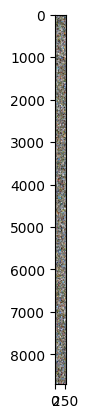

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

In [16]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(16)))

Predicted:  cat   ship  plane plane frog  frog  truck frog  cat   car   plane truck cat   horse car   ship 


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


After 30 epochs accuracy is 68%

After 40 epochs accuracy is 69%

### Performance comparison

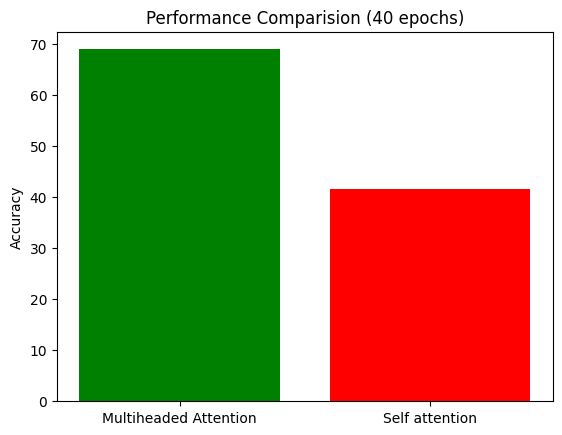

In [5]:
import matplotlib.pyplot as plt

Y = [69,41.53]
X = ["Multiheaded Attention","Self attention"]
plt.bar(X,Y,color =["green","red"])
plt.title('Performance Comparision (40 epochs)')
plt.ylabel('Accuracy')
plt.show()
